## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from time import time, sleep
from random import choice
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Prepare for viewing long text in CSVs

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the two data files

In [4]:
subtweets_data = json.load(open("../data/other_data/subtweets.json"))

In [5]:
non_subtweets_data = json.load(open("../data/other_data/non_subtweets.json"))

#### Find the length of the smaller dataset

In [6]:
largest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Check the lengths and see examples
#### Cut down both datasets to be the same size

In [7]:
subtweets_data = [t["tweet_data"]["full_text"] for t in subtweets_data][:largest_length]

In [8]:
print("Subtweets dataset length: {}".format(len(subtweets_data)))

Subtweets dataset length: 4257


In [9]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
THIS ISN'T BASKETBALL https://t.co/ZZjm9fZfOi


In [10]:
non_subtweets_data = [t["tweet_data"]["full_text"] for t in non_subtweets_data][:largest_length]

In [11]:
print("Non-subtweets dataset length: {}".format(len(non_subtweets_data)))

Non-subtweets dataset length: 4257


In [12]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
I Am A Hero: Not only is this a great Zombie story, it makes a good point about why you should live for someone other than yourself. Hideo has been waiting his whole life for a chance to shine &amp; it finally comes, but only at the expense of all those who care about him  9.5/10 🏆 https://t.co/j4FGOnsx9i


#### Prepare data for training

In [13]:
subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                   "subtweet") for tweet in subtweets_data]

In [14]:
non_subtweets_data = [(tweet.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                       "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [15]:
training_data = subtweets_data + non_subtweets_data

#### (Do not) create training and test sets from the single training set I made before

In [16]:
# text_train, text_test, class_train, class_test = train_test_split([row[0] for row in training_data], 
#                                                                   [row[1] for row in training_data], test_size=0.1)

#### Use NLTK's tokenizer instead of Scikit's

In [17]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [18]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        others = ["You", "You're", "Youre", "Your", "Yours", "U", "Ur", "Urs",
                  "She", "She's", "Shes", "Her", "Hers", 
                  "He", "He's", "Hes", "Him", "His", 
                  "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        others_lower = set([other.lower() for other in others])
        
        selfs = ["I", "I'm", "Im", "We", "We're", "Our", "Ours", "My", "Mine", "Us"]
        selfs_lower = set([self.lower() for self in selfs])
        
        names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
                
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_others = len(others_lower.intersection(tokenized_text))
            num_selfs = len(selfs_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            num_names = len(names_lower.intersection(tokenized_text))
            
            weighted_dict = {"num_others": num_others,
                             "num_selfs": num_selfs,
                             "num_at_symbols": num_at_symbols,
                             "num_subtweet": num_subtweet,
                             "num_urls": num_urls, 
                             "num_names": num_names}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [19]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [20]:
text_training_data = np.array([row[0] for row in training_data])

In [21]:
class_training_data = np.array([row[1] for row in training_data])

In [22]:
kf = KFold(n_splits=10, random_state=7, shuffle=True)

In [23]:
cnf_matrix = np.zeros((2, 2), dtype=int)
for train_index, test_index in kf.split(text_training_data):
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
    
    # print(predictions)
    
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

non-subtweet       0.73      0.64      0.68       402
    subtweet       0.71      0.79      0.75       450

 avg / total       0.72      0.72      0.72       852

              precision    recall  f1-score   support

non-subtweet       0.76      0.63      0.69       446
    subtweet       0.66      0.78      0.71       406

 avg / total       0.71      0.70      0.70       852

              precision    recall  f1-score   support

non-subtweet       0.73      0.61      0.67       433
    subtweet       0.66      0.77      0.71       419

 avg / total       0.70      0.69      0.69       852

              precision    recall  f1-score   support

non-subtweet       0.73      0.62      0.67       429
    subtweet       0.66      0.77      0.71       423

 avg / total       0.70      0.69      0.69       852

              precision    recall  f1-score   support

non-subtweet       0.74      0.62      0.67       439
    subtweet   

#### Define function for visualizing confusion matrices

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")

#### Show the matrices

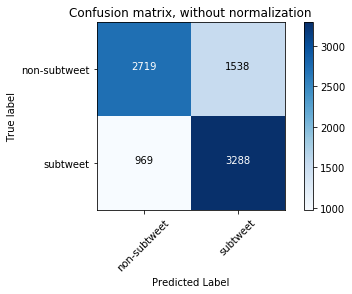

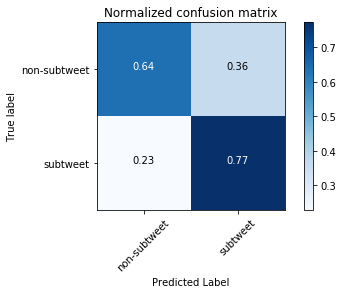

In [25]:
class_names = ["non-subtweet", "subtweet"]

# cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Update matplotlib style

In [26]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [27]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [28]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [29]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [30]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [31]:
%%time
tests_dataframe(test_tweets_df, text_column="Tweet", 
                sentiment_column="Sentiment").drop(["sentiment_score", 
                                                    "subtweet_negative_probability"], axis=1).head()

CPU times: user 11.8 ms, sys: 3.39 ms, total: 15.2 ms
Wall time: 13.2 ms


,subtweet_positive_probability,tweet
1,0.903619,Isn't it funny how some people don't know their place?
2,0.882422,How come you people act like this?
0,0.869064,Some people don't know their place.
3,0.823946,You're such a nerd.
4,0.696903,"I love Noah, he's so cool."


#### Test on actual tweets

In [32]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [33]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [34]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [35]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [36]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### (Don't) use randomly selected 5K rows from dataset

In [37]:
# naji_df = naji_df.sample(n=5000).reset_index(drop=True)

#### Print and time the tests

In [38]:
%%time
naji_df = tests_dataframe(naji_df).drop(["sentiment_score", "subtweet_negative_probability"], axis=1)

CPU times: user 5min 18s, sys: 6.99 s, total: 5min 25s
Wall time: 5min 42s


In [39]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

In [40]:
naji_df.head()

,subtweet_positive_probability,tweet
1395228,0.985636,don't you just hate it when you're talking to someone on MSN and they don't respond for ages and you think you've made them upset
1255435,0.984633,thinks people really dont understand even when their words to you say they do u think something then realise something else
558945,0.981561,"Again, thanks!I hate when you make me realize that you're too good a friend to me.As ur friend I want to tell u, u need better friends."
991591,0.980848,Its funny when people say they'll be there to help if you need them yet when time comes they're not or all they do is complain about it.
1371408,0.980378,and they think you r ignoring them or being rude when really all you want to do is text them back I HATE THAT. lol...


#### Plot the results

In [41]:
naji_df_for_plotting = naji_df.drop(["tweet"], axis=1)

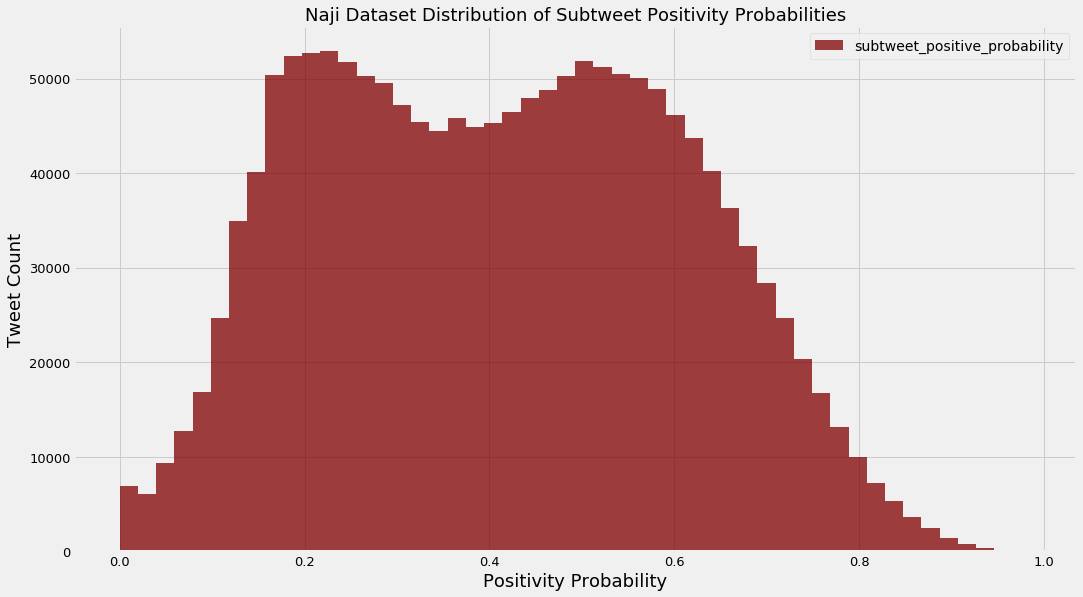

In [42]:
ax = naji_df_for_plotting.plot.hist(bins=50, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Naji Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Tests on friends' tweets

#### Aaron

In [43]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [44]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

CPU times: user 634 ms, sys: 19 ms, total: 653 ms
Wall time: 671 ms


In [45]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [46]:
aaron_df.head()

,subtweet_positive_probability,tweet
1600,0.952488,"shoutout to all the people tweeting #BeforeTheInternetExisted saying ""we actually talked to people face to face"" bc u know they're guilty"
821,0.948784,tfw you're proud of something and want to share it with others but you realize that nobody actually cares
2893,0.946544,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
3318,0.942164,"If you don't follow me on Instagram, you're missing outpic.twitter.com/B2U8aJvSY3"
2445,0.939290,If you don't have tweet notifications turned on for me are we really friends


In [47]:
aaron_df_for_plotting = aaron_df.drop(["tweet"], axis=1)

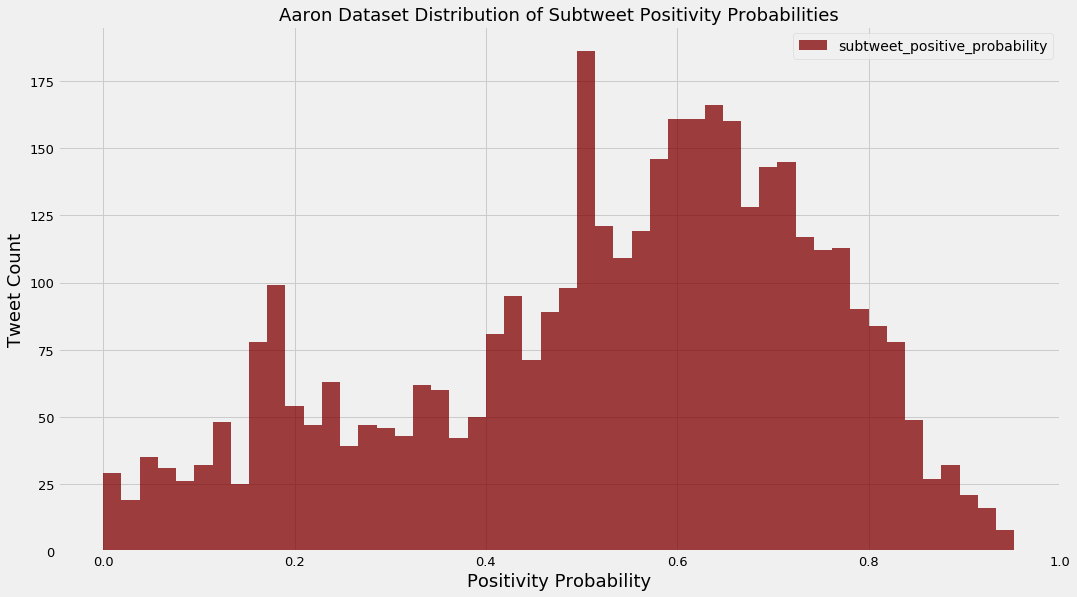

In [48]:
ax = aaron_df_for_plotting.plot.hist(bins=50, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Aaron Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Julia

In [49]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [50]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

CPU times: user 1.41 s, sys: 14.1 ms, total: 1.43 s
Wall time: 1.43 s


In [51]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [52]:
julia_df.head()

,subtweet_positive_probability,tweet
2926,0.967505,"if ur white and u didn't grow up saying ""y'all"" but you do now bc #trendy, consider NOT doing that"
4395,0.965911,"if you continually cross post content on various social media to get validation that you're funny, you, regrettably, are probably not funny"
4629,0.956670,how do you tell ur coach who probably hates ur forgetful ass at this point that you can't go to practice bc u stayed up all night lmk
4197,0.955058,u kno the feel where u rly want to tweet about a part of ur life to get feelings out but u can't bc it could be regarded as a subtweet?? ya
6569,0.950311,tfw really wanting to get out of class to work on ur essay but once ur back in ur dorm u want to do ANYTHING BUT WRITE THIS ESSAY


In [53]:
julia_df_for_plotting = julia_df.drop(["tweet"], axis=1)

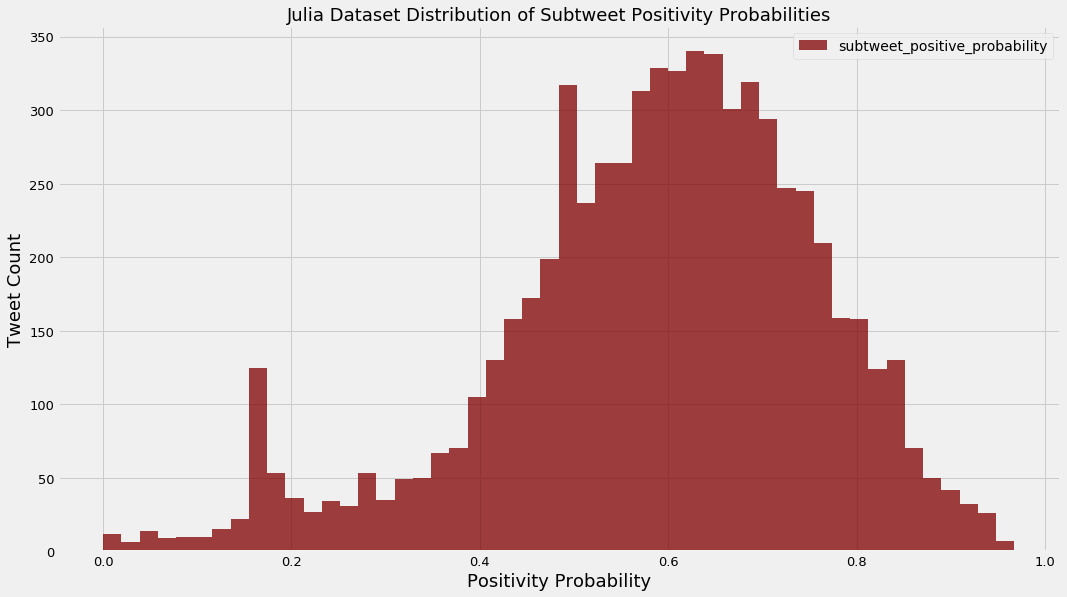

In [54]:
ax = julia_df_for_plotting.plot.hist(bins=50, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Julia Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Zoe

In [55]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [56]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", 
                         sentiment_column="Sentiment").drop(["sentiment_score",
                                                             "subtweet_negative_probability"], axis=1)

CPU times: user 236 ms, sys: 4.21 ms, total: 241 ms
Wall time: 253 ms


In [57]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [58]:
zoe_df.head()

,subtweet_positive_probability,tweet
583,0.956898,"and u decide to tweet about it weeks later bc no one ever talked about it and ur anxious mind decided 2 interpret that as no one caring when, in reality, it's probably people forgetting because you, and your particular brand of anxiety, bounce haphazardly from one mood 2 the ..."
303,0.945935,they say pets can sense when ur Not Okay™ and I think it's true bc pinwheel refuses to fall asleep anywhere but on my lap/chest
1115,0.944989,if u don't watch all ur snap friends stories ur probably 2 self-involved
456,0.943692,when ur heart rate is fast before bed and u can't tell if it's the anxiety heart rate or the insomnia heart rate BUT you realize you're not anxious so it's probably the insomnia \n\nwelcome back old friend you have not been missed
788,0.943055,u ever read a tweet and ur like damn did u write that just to upset me??? Well it only worked for three seconds


In [59]:
zoe_df_for_plotting = zoe_df.drop(["tweet"], axis=1)

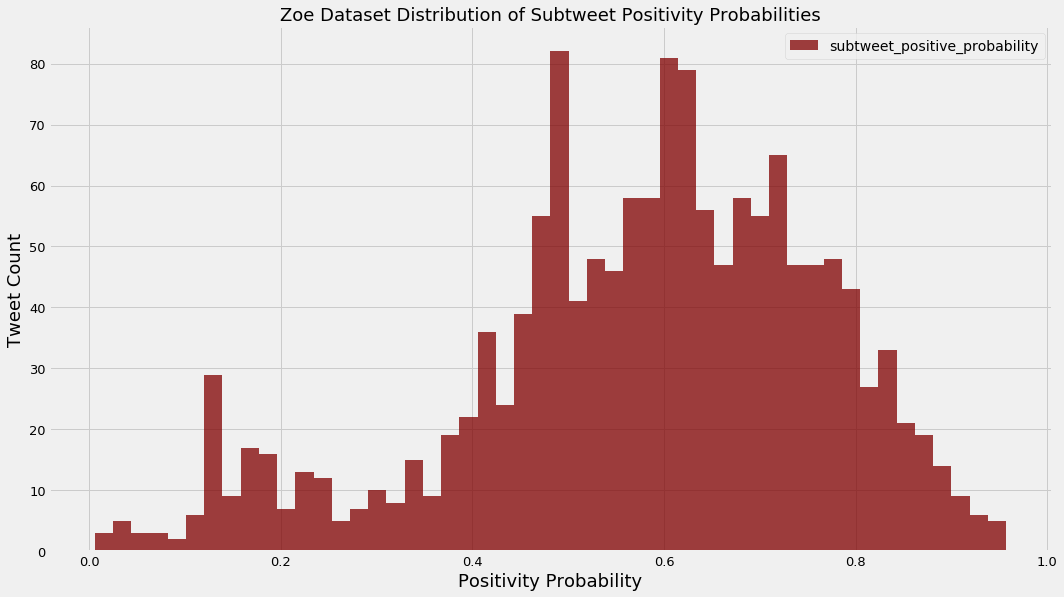

In [60]:
ax = zoe_df_for_plotting.plot.hist(bins=50, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Zoe Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);

#### Noah

In [61]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [62]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", 
                          sentiment_column="Sentiment").drop(["sentiment_score", 
                                                              "subtweet_negative_probability"], axis=1)

CPU times: user 825 ms, sys: 9.22 ms, total: 834 ms
Wall time: 839 ms


In [63]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [64]:
noah_df.head()

,subtweet_positive_probability,tweet
4166,0.969665,TFW your old boss walks into DTR and you feel like you're supposed to look like you're working even though you don't work for her
2891,0.966618,When you're telling me to die or making me feel inferior I don't like you but you're normally very kind so I'm content with that
4192,0.961289,You ever wonder how your siblings are when you're not with them? haha me neither
3236,0.957128,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
696,0.955356,"I FIGURED OUT THAT I DON'T REALLY KNOW\nIt's not satirizing anything in particular, and he's completely genuine across all his comedy pieces. I've described it before as ""broken comedy"" because it's not quite entirely nonsensical but it's really clearly funny because it's bad."


In [65]:
noah_df_for_plotting = noah_df.drop(["tweet"], axis=1)

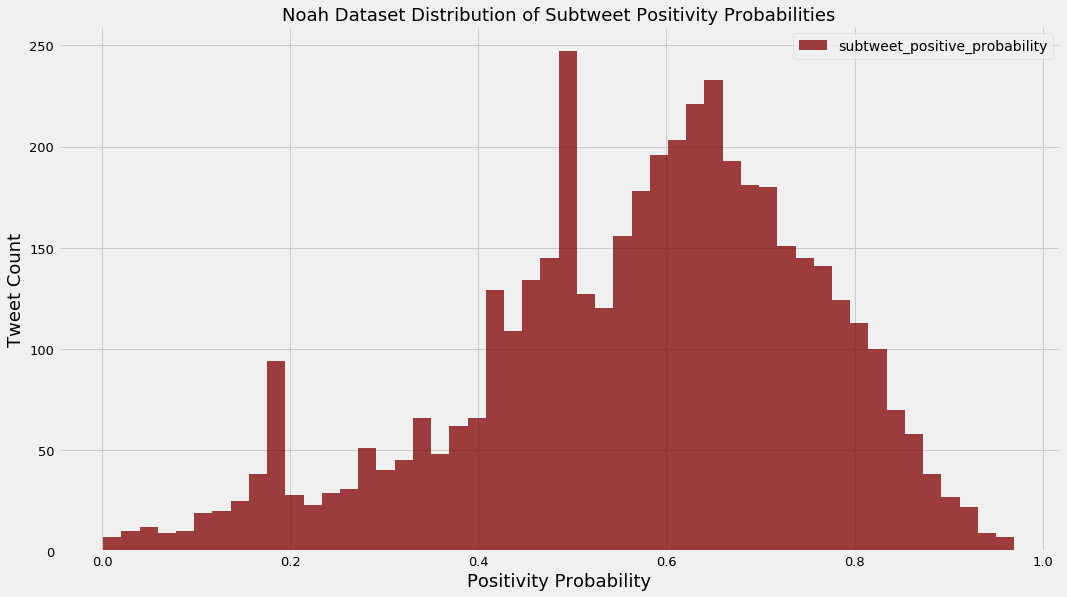

In [66]:
ax = noah_df_for_plotting.plot.hist(bins=50, figsize=(16, 9), color="maroon", alpha=0.75, fontsize=13);
ax.set_title("Noah Dataset Distribution of Subtweet Positivity Probabilities", fontsize=18)
ax.set_xlabel("Positivity Probability", fontsize=18);
ax.set_ylabel("Tweet Count", fontsize=18);